In [2]:
import argparse
import time
import numpy as np
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import optim

# from model import RW_NN
from utils import load_data, generate_batches, accuracy, AverageMeter

In [3]:
import torch
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs available:", torch.cuda.device_count())
# print("CUDA Device Name:", torch.cuda.get_device_name(0))

2.5.1+cu124
CUDA Available: True
Number of GPUs available: 1


In [4]:
# settings
from types import SimpleNamespace
args = SimpleNamespace(
    dataset='graph',
    use_node_labels=False,
    lr=1e-2,
    dropout=0.2,
    batch_size=64,
    epochs=100,
    hidden_graphs=16,
    size_hidden_graphs=5,
    hidden_dim=4,
    penultimate_dim=5,
    max_step=2,
    normalize=False,
    num_samples=8
)

In [5]:
device = torch.device("cpu")

In [6]:
adj_lst, features_lst, class_labels = load_data(args.dataset, args.use_node_labels)

N = len(adj_lst)
features_dim = features_lst[0].shape[1]

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)
n_classes = np.unique(class_labels).size
y = [np.array(class_labels[i]) for i in range(class_labels.size)]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
it = 0
accs = list()

In [7]:
# THE MODEL
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, average_precision_score
import scipy.sparse as sp
import numpy as np
import os
import time
import networkx as nx
from input_data import load_data
from preprocessing import preprocess_graph
import vgae_model
from types import SimpleNamespace
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random

vgae_args = SimpleNamespace(
    ### CONFIGS ###
    model = 'VGAE',
    input_dim = args.size_hidden_graphs, 
    hidden1_dim = 4,
    hidden2_dim = 3,
    use_feature = True,
    num_epoch = 25,
    learning_rate = 0.01
)

class RW_NN(nn.Module):
    # new hyperparameters
    # max_num_children
    def __init__(self, input_dim, max_step, hidden_graphs, size_hidden_graphs, hidden_dim, penultimate_dim, normalize, n_classes, dropout, device):
        super(RW_NN, self).__init__()
        self.max_step = max_step
        self.hidden_graphs = hidden_graphs
        self.size_hidden_graphs = size_hidden_graphs
        self.normalize = normalize
        self.device = device

        self.adj_hidden = Parameter(torch.FloatTensor(hidden_graphs, (size_hidden_graphs*(size_hidden_graphs-1))//2))
        self.adj_hidden_tree = None
        self.adj_hidden_tree_norm = None
        self.features_hidden = Parameter(torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim))
        self.hidden_dim = hidden_dim
        self.features_hidden_tree = None
        self.input_dim = input_dim
        self.penultimate_dim = penultimate_dim

        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_graphs*max_step)
        self.fc1 = torch.nn.Linear(hidden_graphs*max_step, penultimate_dim)
        self.fc2 = torch.nn.Linear(penultimate_dim, n_classes)

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()
        
        self.metagraph = None
        self.cluster_labels = None
        self.vgae_graphs = None


    def init_weights(self):
        self.adj_hidden.data.uniform_(-1, 1)
        self.features_hidden.data.uniform_(0, 1)

        
    def forward(self, adj, features, graph_indicator, y=None):
        if self.training:
            unique, counts = torch.unique(graph_indicator, return_counts=True)
            n_graphs = unique.size(0)
            n_nodes = features.size(0)

            if self.normalize:
                norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
            
            adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
            idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
            adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
            adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
            x = self.sigmoid(self.fc(features))
            z = self.features_hidden
            zx = torch.einsum("abc,dc->abd", (z, x))
            
            out = list()
            for i in range(self.max_step):
                if i == 0:
                    eye = torch.eye(self.size_hidden_graphs, device=self.device)
                    eye = eye.repeat(self.hidden_graphs, 1, 1)              
                    o = torch.einsum("abc,acd->abd", (eye, z))
                    t = torch.einsum("abc,dc->abd", (o, x))
                else:
                    x = torch.spmm(adj, x)
                    z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                    t = torch.einsum("abc,dc->abd", (z, x))
                t = self.dropout(t)
                t = torch.mul(zx, t)
                t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
                t = torch.sum(t, dim=1)
                t = torch.transpose(t, 0, 1)
                if self.normalize:
                    t /= norm
                out.append(t)
                
            out = torch.cat(out, dim=1)
            out = self.bn(out)
            out = self.relu(self.fc1(out))
            out = self.dropout(out)
            out = self.fc2(out)
            return F.log_softmax(out, dim=1)
        else:
            num_samples = args.num_samples
            adj_hidden_vgae, vgae_features = self.run_vgae(num_samples)
            unique, counts = torch.unique(graph_indicator, return_counts=True)
            n_graphs = unique.size(0)
            n_nodes = features.size(0)

            if self.normalize:
                norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)


            adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
            idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
            adj_hidden_norm[:,idx[0],idx[1]] = self.relu(adj_hidden_vgae)
            adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
            x = self.sigmoid(self.fc(features))
            z = self.features_hidden
            zx = torch.einsum("abc,dc->abd", (z, x))
            
            out = list()
            for i in range(self.max_step):
                if i == 0:
                    eye = torch.eye(self.size_hidden_graphs, device=self.device)
                    eye = eye.repeat(self.hidden_graphs, 1, 1)              
                    o = torch.einsum("abc,acd->abd", (eye, z))
                    t = torch.einsum("abc,dc->abd", (o, x))
                else:
                    x = torch.spmm(adj, x)
                    z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                    t = torch.einsum("abc,dc->abd", (z, x))
                t = self.dropout(t)
                t = torch.mul(zx, t)
                t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
                t = torch.sum(t, dim=1)
                t = torch.transpose(t, 0, 1)
                if self.normalize:
                    t /= norm
                out.append(t)
                
            out = torch.cat(out, dim=1)
            out = self.bn(out)
            out = self.relu(self.fc1(out))
            out = self.dropout(out)
            out = self.fc2(out)
            return F.log_softmax(out, dim=1)
        

    
    def get_hidden_graphs_adjacency_list(self):
        """Converts the upper-triangular adjacency data to adjacency lists."""
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        
        # Convert each hidden graph's adjacency matrix to an adjacency list
        adjacency_lists = []
        for i in range(self.hidden_graphs):
            adj_list = {}
            adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
            for row in range(adj_matrix.shape[0]):
                adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
            adjacency_lists.append(adj_list)
        
        return adjacency_lists
    


# VGAE METHODS
    def sparse_to_tuple(self, sparse_mx):
        if not sp.isspmatrix_coo(sparse_mx):
            sparse_mx = sparse_mx.tocoo()
        coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
        values = sparse_mx.data
        shape = sparse_mx.shape
        return coords, values, shape
    def mask_test_edges(self, adj):
        adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
        adj.eliminate_zeros()

        adj_triu = sp.triu(adj)
        adj_tuple = self.sparse_to_tuple(adj_triu)
        edges = adj_tuple[0]

        num_edges = edges.shape[0]
        if num_edges < 10:
            # print("Not enough edges for a split. Using all edges for training.")
            return edges, [], []  # Return all edges for training, no validation/test

        num_test = int(np.floor(num_edges / 10.))
        num_val = int(np.floor(num_edges / 20.))

        all_edge_idx = list(range(num_edges))
        np.random.shuffle(all_edge_idx)
        val_edge_idx = all_edge_idx[:num_val]
        test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]

        test_edges = edges[test_edge_idx] if test_edge_idx else []
        val_edges = edges[val_edge_idx] if val_edge_idx else []
        if test_edge_idx or val_edge_idx:
            train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)
        else:
            train_edges = edges

        return train_edges, val_edges, test_edges
    def get_acc(self, adj_rec, adj_label):
        labels_all = adj_label.to_dense().view(-1).long()
        preds_all = (adj_rec > 0.5).view(-1).long()
        accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
        return accuracy
    
    def genMetaGraphs(self, graph_dist_adj_matrix):
        G = nx.from_numpy_array(graph_dist_adj_matrix)

        pos = nx.spring_layout(G)

        nx.draw_networkx_nodes(G, pos)

        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.show()
    # NUM_SAMPLES = NUM_CLUSTERS
    def getSamples(self, num_samples):
        adjacency_lists = self.get_hidden_graphs_adjacency_list()
        for graph_id, adj_list in enumerate(adjacency_lists):
            if len(adj_list) != 5:
                print("FIRST ONE NOT GOOD")
                raise ValueError(f"Graph {graph_id} does not have exactly 5 nodes. It has {len(adj_list)} nodes.")
        graphs = []

        # Draw the adjacency list as a graph using NetworkX and Matplotlib
        for i, adj_list in enumerate(adjacency_lists):
            G = nx.Graph()  # Create a new graph
            # Add edges to the graph based on the adjacency list
            for node, neighbors in adj_list.items():
                G.add_node(node)
                for neighbor in neighbors:
                    G.add_edge(node, neighbor)

            if len(G.nodes) != 5:
                raise ValueError(f"Graph {i} does not have exactly 5 nodes. It has {len(G.nodes)} nodes.")

            # for j, graph in enumerate(graphs):
            #     if nx.is_isomorphic(graph, G):
            #         print("Graph", i, "is isomorphic to previous graph", j)
            graphs.append(G)

        #Edit distance
        graph_dist_adj_matrix = np.zeros(shape=(len(graphs),len(graphs)))
        
        for i, graph_1 in enumerate(graphs):
            for j, graph_2 in enumerate(graphs):
                if i == j:
                    continue

                graph_edit_distance = nx.graph_edit_distance(graph_1, graph_2)
                # print('Edit distance between graph', i, ' and graph', j, ':', graph_edit_distance)
                graph_dist_adj_matrix[i, j] = graph_edit_distance
        
        graph_dist_adj_matrix_rounded = np.round(graph_dist_adj_matrix, 3)

        G = nx.from_numpy_array(graph_dist_adj_matrix_rounded)
        self.metagraph = G
        # pos = nx.spring_layout(G)

        # nx.draw_networkx_nodes(G, pos)

        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edges(G, pos)
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        # plt.show()
        # Perform clustering
        # use metagraph adjacency matrix as node features
        node_features = graph_dist_adj_matrix

        # apply PCA for dimensionality reduction
        pca = PCA(n_components=2)  # Reduce to 2 components for visualization
        reduced_features = pca.fit_transform(node_features)
        
        # apply clustering
        num_clusters = num_samples
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_features)

        self.cluster_labels = cluster_labels
        # visualize metagraph with cluster labels
        # pos = nx.spring_layout(G)  # Spring layout for visualization
        # nx.draw_networkx_nodes(G, pos, node_color=cluster_labels, cmap='viridis', node_size=300)
        # nx.draw_networkx_edges(G, pos, alpha=0.5)

        # # Draw edge labels (weights)
        # weights = nx.get_edge_attributes(G, "weight")
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8)


        # # Add labels (optional)
        # nx.draw_networkx_labels(G, pos, font_size=10)
        # plt.title("Clustering of Meta-Graph Nodes")
        # plt.show()
        
        # Step 1: Group graph indices by cluster labels
        cluster_to_graphs = {i: [] for i in range(num_clusters)}
        for graph_idx, cluster_id in enumerate(cluster_labels):
            cluster_to_graphs[cluster_id].append(graph_idx)
            graph = graphs[graph_idx]  # Get the graph corresponding to the index
            # Check  if the graph has exactly 5 nodes
            if len(graph.nodes) != 5:
                raise ValueError(f"Graph {graph_idx} in cluster {cluster_id} does not have exactly 5 nodes. It has {len(graph.nodes)} nodes.")
        # print(cluster_labels)
        # Step 2: Sample one graph per cluster
        sampled_graphs = {}
        for cluster_id, graph_indices in cluster_to_graphs.items():
            if graph_indices:
                sampled_graph = random.choice(graph_indices)  # Randomly sample one graph
                sampled_graphs[cluster_id] = graphs[sampled_graph]  # Retrieve the actual graph
        # print(sampled_graphs)
        # Step 3: (Optional) Visualize sampled graphs
        # for cluster_id, graph in sampled_graphs.items():
        #     plt.figure(figsize=(6, 6))
        #     nx.draw(graph, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
        #     plt.title(f"Graph Sampled from Cluster {cluster_id}")
        #     plt.show()

        # Step 4: Represent sampled graphs as adjacency matrices
        sampled_adj_matrices = {}
        for cluster_id, graph in sampled_graphs.items():
            if graph:
            # Convert the graph to an adjacency matrix
                adj_matrix = nx.adjacency_matrix(graph).toarray()  # Convert sparse matrix to dense
                sampled_adj_matrices[cluster_id] = adj_matrix

        return sampled_adj_matrices

    def run_vgae(self, num_samples):
        
        adjacency_lists = self.getSamples(num_samples)
        
        # Train on CPU (hide GPU) due to memory constraints
        # os.environ['CUDA_VISIBLE_DEVICES'] = ""
        upper_tri_values_list = [None] * self.hidden_graphs
        adj_num = 0

        features_list = []
        self.vgae_graphs = []
        for adj in adjacency_lists:
            adj = adjacency_lists[0]
            # Check if adj is a PyTorch tensor and convert it to scipy sparse matrix
            if isinstance(adj, torch.Tensor):
                adj = adj.cpu().numpy()  # Convert tensor to numpy array
                adj = sp.coo_matrix(adj)  # Convert numpy array to sparse matrix

            # Ensure adjacency matrix is sparse (in case it's not already)
            if not sp.isspmatrix(adj):
                adj = sp.coo_matrix(adj)

            # Generate feature matrix (identity matrix in sparse format)
            num_nodes = adj.shape[0]
            features = sp.identity(num_nodes).tolil()

            # Store original adjacency matrix (without diagonal entries)
            adj_orig = adj
            adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
            adj_orig.eliminate_zeros()


            # Mask the edges (train/validation/test split)
            train_edges, val_edges, test_edges = self.mask_test_edges(adj)

            # Using the training adjacency matrix
            adj_train = adj  # Assuming adj_train is returned or defined within mask_test_edges
            adj_norm = preprocess_graph(adj)
            num_nodes = adj.shape[0]

            features = self.sparse_to_tuple(features.tocoo())
            num_features = features[2][1]
            features_nonzero = features[1].shape[0]

            # Create Model
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)


            adj_label = adj_train + sp.eye(adj_train.shape[0])
            adj_label = self.sparse_to_tuple(adj_label)



            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                                        torch.FloatTensor(adj_norm[1]), 
                                        torch.Size(adj_norm[2]))
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                                        torch.FloatTensor(adj_label[1]), 
                                        torch.Size(adj_label[2]))
            features = torch.sparse.FloatTensor(torch.LongTensor(features[0].T), 
                                        torch.FloatTensor(features[1]), 
                                        torch.Size(features[2]))

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0)) 
            weight_tensor[weight_mask] = pos_weight

            # init model and optimizer
            model = getattr(vgae_model,vgae_args.model)(adj_norm, vgae_args.input_dim, vgae_args.hidden1_dim, vgae_args.hidden2_dim) 
            optimizer = Adam(model.parameters(), lr=vgae_args.learning_rate)
            # Initialize VGAE model with the adjacency matrix
            adj_dense = torch.tensor(adj.toarray(), dtype=torch.float32)  # Ensure it's a tensor
            model = vgae_model.VGAE(adj_dense, vgae_args.input_dim, vgae_args.hidden1_dim, vgae_args.hidden2_dim)  # Make sure to pass the adjacency matrix during initialization
            # Training loop
            for epoch in range(vgae_args.num_epoch):
                t = time.time()

                # Pass the features to the model
                A_pred = model(features)
                
                optimizer.zero_grad()
                
                # Compute loss
                loss = log_lik = norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight=weight_tensor)
                
                if vgae_args.model == 'VGAE':
                    # KL divergence regularization
                    kl_divergence = 0.5 / A_pred.size(0) * (1 + 2 * model.logstd - model.mean**2 - torch.exp(model.logstd)**2).sum(1).mean()
                    loss -= kl_divergence

                # Backpropagate and optimize
                loss.backward()
                optimizer.step()

                # Compute train accuracy
                train_acc = self.get_acc(A_pred, adj_label)

            # Get latent embeddings (mean and log standard deviation)
            z_mean = model.mean
            z_log_std = model.logstd

            # Sample latent variables from the Gaussian distribution
            z_sampled = z_mean + torch.randn_like(z_log_std) * torch.exp(z_log_std)
            features = z_sampled
            features_list.append(features)

            # Decode the sampled latent variables to generate a new adjacency matrix
            new_adj_rec = torch.sigmoid(torch.matmul(z_sampled, z_sampled.t()))
            # Generate binary adjacency matrix (threshold the probabilities)
            threshold = 0.5  # Adjust the threshold as needed
            new_adj_binary = (new_adj_rec > threshold).float()
            
            G = nx.Graph()

            # Add edges based on the binary adjacency matrix
            num_nodes = new_adj_binary.shape[0]
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if new_adj_binary[i, j] == 1:  # If there's an edge
                        G.add_edge(i, j)
            self.vgae_graphs.append(G)
            # Visualize the graph

            # convert to a tensor
            new_adj_sparse = sp.coo_matrix(new_adj_binary.detach().cpu().numpy())
            # Ensure adj is in sparse format after edge masking

            # Step 1: Convert sparse matrix to dense format
            new_adj_dense = new_adj_sparse.toarray()  # Convert sparse COO matrix to dense array

            # Step 2: Convert to PyTorch tensor
            new_adj_tensor = torch.tensor(new_adj_dense, dtype=torch.float32, device=self.device)

            # Step 3: Extract upper triangular values (excluding diagonal)
            idx = torch.triu_indices(new_adj_tensor.size(0), new_adj_tensor.size(1), offset=1)
            upper_tri_values = new_adj_tensor[idx[0], idx[1]]  # Extract upper triangular values

            iter = 0

            for cluster_label in self.cluster_labels:
                if(cluster_label == adj_num):
                    upper_tri_values_list[iter] = upper_tri_values
                iter += 1
            adj_num += 1

            # Step 4: Assign to self.adj_hidden
            # if upper_tri_values.shape[0] != self.adj_hidden.shape[1]:
            #     raise ValueError(f"Size mismatch: upper_tri_values has {upper_tri_values.shape} shape, but self.adj_hidden expects {self.adj_hidden.shape}.")
        for i, value in enumerate(upper_tri_values_list):
            if value is None:
                upper_tri_values_list[i] = torch.zeros(self.adj_hidden.shape[1])
        all_upper_tri_values = torch.stack(upper_tri_values_list, dim=0)  # Concatenate along the first dimension
        all_features = torch.stack(features_list, dim=0)  # Concatenate along the first dimension
        return all_upper_tri_values, all_features
    def get_vgae_graphs(self):
        return self.vgae_graphs
    def get_cluster_lables(self):
        return self.cluster_labels
    def get_meta_graph(self):
        return self.metagraph

In [8]:
for train_index, test_index in kf.split(y):
    it += 1
    
    idx = np.random.permutation(train_index)
    train_index = idx[:int(idx.size*0.9)].tolist()
    val_index = idx[int(idx.size*0.9):].tolist()

    n_train = len(train_index)
    n_val = len(val_index)
    n_test = len(test_index)

    adj_train = [adj_lst[i] for i in train_index]
    features_train = [features_lst[i] for i in train_index]
    y_train = [y[i] for i in train_index]

    adj_val = [adj_lst[i] for i in val_index]
    features_val = [features_lst[i] for i in val_index]
    y_val = [y[i] for i in val_index]

    adj_test = [adj_lst[i] for i in test_index]
    features_test = [features_lst[i] for i in test_index]
    y_test = [y[i] for i in test_index]

    adj_train, features_train, graph_indicator_train, y_train = generate_batches(adj_train, features_train, y_train, args.batch_size, device)
    adj_val, features_val, graph_indicator_val, y_val = generate_batches(adj_val, features_val, y_val, args.batch_size, device)
    adj_test, features_test, graph_indicator_test, y_test = generate_batches(adj_test, features_test, y_test, args.batch_size, device)

    n_train_batches = ceil(n_train/args.batch_size)
    n_val_batches = ceil(n_val/args.batch_size)
    n_test_batches = ceil(n_test/args.batch_size)
    
    model = RW_NN(features_dim, args.max_step, args.hidden_graphs, args.size_hidden_graphs, args.hidden_dim, args.penultimate_dim, args.normalize, n_classes, args.dropout, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def train(epoch, adj, features, graph_indicator, y):
        optimizer.zero_grad()
        output = model(adj, features, graph_indicator)
        loss_train = F.cross_entropy(output, y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train

    def test(adj, features, graph_indicator, y):
        output = model(adj, features, graph_indicator)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test

    best_acc = 0

    for epoch in range(args.epochs):
        start = time.time()
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()

        # Train for one epoch
        for i in range(n_train_batches):
            output, loss = train(epoch, adj_train[i], features_train[i], graph_indicator_train[i], y_train[i])
            train_loss.update(loss.item(), output.size(0))
            train_acc.update(accuracy(output.data, y_train[i].data), output.size(0))

        # Evaluate on validation set every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == args.epochs - 1:  # Always evaluate at the last epoch
            model.eval()
            val_loss = AverageMeter()
            val_acc = AverageMeter()

            for i in range(n_val_batches):
                output, loss = test(adj_val[i], features_val[i], graph_indicator_val[i], y_val[i])
                val_loss.update(loss.item(), output.size(0))
                val_acc.update(accuracy(output.data, y_val[i].data), output.size(0))

            # Print validation results
            print("Cross-val iter:", '%02d' % it, "epoch:", '%03d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss.avg),
                "train_acc=", "{:.5f}".format(train_acc.avg), "val_loss=", "{:.5f}".format(val_loss.avg),
                "val_acc=", "{:.5f}".format(val_acc.avg), "time=", "{:.5f}".format(time.time() - start))

            # Remember best accuracy and save checkpoint
            is_best = val_acc.avg >= best_acc
            best_acc = max(val_acc.avg, best_acc)
            if is_best:
                early_stopping_counter = 0
                torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }, 'model_best.pth.tar')

        # Adjust learning rate
        scheduler.step()

    print("Optimization finished!")

    # Testing
    test_loss = AverageMeter()
    test_acc = AverageMeter()
    print("Loading checkpoint!")
    checkpoint = torch.load('model_best.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


    for i in range(n_test_batches):
        output, loss = test(adj_test[i], features_test[i], graph_indicator_test[i], y_test[i])
        test_loss.update(loss.item(), output.size(0))
        test_acc.update(accuracy(output.data, y_test[i].data), output.size(0))
    accs.append(test_acc.avg.cpu().numpy())

    # Print results
    print("test_loss=", "{:.5f}".format(test_loss.avg), "test_acc=", "{:.5f}".format(test_acc.avg))
    print()

    print("avg_test_acc=", "{:.5f}".format(np.mean(accs)))


e:\CS\CS292F\hrwgnn\utils.py:44: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:653.)
  return torch.sparse.FloatTensor(indices, values, shape)
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 010 train_loss= 0.04495 train_acc= 0.96543 val_loss= 2.88010 val_acc= 0.55556 time= 1.73239


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 020 train_loss= 0.03108 train_acc= 0.97778 val_loss= 4.62302 val_acc= 0.55556 time= 1.70045


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 030 train_loss= 0.02784 train_acc= 0.97037 val_loss= 4.10044 val_acc= 0.55556 time= 1.72780


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 040 train_loss= 0.03318 train_acc= 0.97284 val_loss= 4.01987 val_acc= 0.55556 time= 1.73391


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 050 train_loss= 0.02032 train_acc= 0.99012 val_loss= 2.65664 val_acc= 0.55556 time= 1.68599


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 060 train_loss= 0.03958 train_acc= 0.96790 val_loss= 3.41573 val_acc= 0.55556 time= 1.66197


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 070 train_loss= 0.01872 train_acc= 0.99012 val_loss= 0.08070 val_acc= 1.00000 time= 1.65132


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 080 train_loss= 0.02207 train_acc= 0.99012 val_loss= 7.15108 val_acc= 0.55556 time= 1.65495


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 090 train_loss= 0.02234 train_acc= 0.98025 val_loss= 2.50586 val_acc= 0.55556 time= 1.68006


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 01 epoch: 100 train_loss= 0.03405 train_acc= 0.97778 val_loss= 6.19743 val_acc= 0.55556 time= 1.65187
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 2.83560 test_acc= 0.52000

avg_test_acc= 0.52000


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 010 train_loss= 0.01009 train_acc= 0.99753 val_loss= 2.31516 val_acc= 0.60000 time= 1.28813


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 020 train_loss= 0.02109 train_acc= 0.99012 val_loss= 0.10232 val_acc= 1.00000 time= 1.35177


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 030 train_loss= 0.01454 train_acc= 0.99259 val_loss= 0.71771 val_acc= 0.62222 time= 1.33760


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 040 train_loss= 0.00607 train_acc= 1.00000 val_loss= 1.97882 val_acc= 0.60000 time= 1.35503


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 050 train_loss= 0.01011 train_acc= 0.99506 val_loss= 0.97078 val_acc= 0.62222 time= 1.34872


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 060 train_loss= 0.00999 train_acc= 0.99753 val_loss= 0.41728 val_acc= 0.68889 time= 1.37789


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 070 train_loss= 0.00725 train_acc= 0.99753 val_loss= 0.36728 val_acc= 0.68889 time= 1.34209


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 080 train_loss= 0.00971 train_acc= 0.99753 val_loss= 1.15193 val_acc= 0.62222 time= 1.35740


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 090 train_loss= 0.00843 train_acc= 0.99753 val_loss= 0.38261 val_acc= 0.71111 time= 1.33749


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 02 epoch: 100 train_loss= 0.00397 train_acc= 1.00000 val_loss= 3.12989 val_acc= 0.60000 time= 1.32588
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 0.41357 test_acc= 0.66000

avg_test_acc= 0.59000


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 010 train_loss= 0.22251 train_acc= 1.00000 val_loss= 0.65989 val_acc= 0.60000 time= 1.76171


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 020 train_loss= 0.10302 train_acc= 1.00000 val_loss= 0.21220 val_acc= 1.00000 time= 1.82231


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 030 train_loss= 0.05914 train_acc= 1.00000 val_loss= 0.08170 val_acc= 1.00000 time= 1.69816


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 040 train_loss= 0.03892 train_acc= 1.00000 val_loss= 0.74899 val_acc= 0.60000 time= 1.68662


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 050 train_loss= 0.02775 train_acc= 1.00000 val_loss= 1.20873 val_acc= 0.60000 time= 1.71138


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 060 train_loss= 0.02375 train_acc= 1.00000 val_loss= 1.01602 val_acc= 0.60000 time= 1.70593


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 070 train_loss= 0.02066 train_acc= 1.00000 val_loss= 1.23776 val_acc= 0.60000 time= 1.68487


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 080 train_loss= 0.01804 train_acc= 1.00000 val_loss= 0.02242 val_acc= 1.00000 time= 1.67708


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 090 train_loss= 0.01588 train_acc= 1.00000 val_loss= 0.35384 val_acc= 0.62222 time= 1.70388


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Cross-val iter: 03 epoch: 100 train_loss= 0.01403 train_acc= 1.00000 val_loss= 0.01794 val_acc= 1.00000 time= 1.68918
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 0.10470 test_acc= 1.00000

avg_test_acc= 0.72667


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 010 train_loss= 0.01352 train_acc= 0.99753 val_loss= 0.02426 val_acc= 1.00000 time= 1.53390


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 020 train_loss= 0.01217 train_acc= 1.00000 val_loss= 0.01837 val_acc= 1.00000 time= 1.56854


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 030 train_loss= 0.01017 train_acc= 0.99753 val_loss= 0.00014 val_acc= 1.00000 time= 1.58417


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 040 train_loss= 0.02103 train_acc= 0.99259 val_loss= 0.00037 val_acc= 1.00000 time= 1.54201


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 050 train_loss= 0.01518 train_acc= 0.99259 val_loss= 0.39732 val_acc= 0.68889 time= 1.55336


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 060 train_loss= 0.01599 train_acc= 0.99259 val_loss= 0.00034 val_acc= 1.00000 time= 1.53177


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 070 train_loss= 0.01587 train_acc= 0.99506 val_loss= 0.00001 val_acc= 1.00000 time= 1.53272


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 080 train_loss= 0.00847 train_acc= 0.99753 val_loss= 0.00085 val_acc= 1.00000 time= 1.50639


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 090 train_loss= 0.01407 train_acc= 0.99259 val_loss= 0.01348 val_acc= 1.00000 time= 1.51993


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 04 epoch: 100 train_loss= 0.01015 train_acc= 0.99753 val_loss= 0.00008 val_acc= 1.00000 time= 1.51502
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 0.02368 test_acc= 1.00000

avg_test_acc= 0.79500


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 010 train_loss= 0.02721 train_acc= 1.00000 val_loss= 0.46953 val_acc= 0.60000 time= 1.30084


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 020 train_loss= 0.01057 train_acc= 1.00000 val_loss= 2.19695 val_acc= 0.55556 time= 1.28954


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 030 train_loss= 0.00974 train_acc= 1.00000 val_loss= 0.13675 val_acc= 1.00000 time= 1.29734


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 040 train_loss= 0.00729 train_acc= 1.00000 val_loss= 0.11601 val_acc= 1.00000 time= 1.28208


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 050 train_loss= 0.00552 train_acc= 1.00000 val_loss= 8.21865 val_acc= 0.55556 time= 1.30525


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 060 train_loss= 0.00415 train_acc= 1.00000 val_loss= 5.13429 val_acc= 0.55556 time= 1.28870


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 070 train_loss= 0.00380 train_acc= 1.00000 val_loss= 0.01697 val_acc= 1.00000 time= 1.28627


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 080 train_loss= 0.00382 train_acc= 1.00000 val_loss= 3.14708 val_acc= 0.55556 time= 1.34250


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 090 train_loss= 0.00355 train_acc= 1.00000 val_loss= 1.80068 val_acc= 0.55556 time= 1.33034


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 05 epoch: 100 train_loss= 0.00259 train_acc= 1.00000 val_loss= 6.31953 val_acc= 0.55556 time= 1.26674
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 5.40597 test_acc= 0.46000

avg_test_acc= 0.72800


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 010 train_loss= 0.03996 train_acc= 1.00000 val_loss= 2.74450 val_acc= 0.42222 time= 1.34176


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 020 train_loss= 0.02145 train_acc= 1.00000 val_loss= 3.46894 val_acc= 0.42222 time= 1.36830


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 030 train_loss= 0.01553 train_acc= 1.00000 val_loss= 0.26403 val_acc= 0.88889 time= 1.35048


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 040 train_loss= 0.00964 train_acc= 1.00000 val_loss= 0.08838 val_acc= 0.97778 time= 1.37800


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 050 train_loss= 0.00643 train_acc= 1.00000 val_loss= 0.01565 val_acc= 1.00000 time= 1.38804


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 060 train_loss= 0.00613 train_acc= 1.00000 val_loss= 4.41473 val_acc= 0.42222 time= 1.36141


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 070 train_loss= 0.00494 train_acc= 1.00000 val_loss= 1.86028 val_acc= 0.42222 time= 1.37485


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 080 train_loss= 0.00407 train_acc= 1.00000 val_loss= 2.41940 val_acc= 0.42222 time= 1.38417


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 090 train_loss= 0.00456 train_acc= 1.00000 val_loss= 0.29375 val_acc= 0.88889 time= 1.45394


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 06 epoch: 100 train_loss= 0.00392 train_acc= 1.00000 val_loss= 0.00078 val_acc= 1.00000 time= 1.44639
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 1.95257 test_acc= 0.64000

avg_test_acc= 0.71333


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 010 train_loss= 0.01469 train_acc= 0.99753 val_loss= 0.11464 val_acc= 0.93333 time= 1.50884


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 020 train_loss= 0.01597 train_acc= 0.99506 val_loss= 1.02770 val_acc= 0.55556 time= 1.48487


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 030 train_loss= 0.01680 train_acc= 0.99012 val_loss= 1.61720 val_acc= 0.55556 time= 1.51680


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 040 train_loss= 0.00904 train_acc= 1.00000 val_loss= 1.34920 val_acc= 0.55556 time= 1.45495


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 050 train_loss= 0.01009 train_acc= 0.99753 val_loss= 2.12455 val_acc= 0.53333 time= 1.45133


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 060 train_loss= 0.00976 train_acc= 1.00000 val_loss= 1.08903 val_acc= 0.55556 time= 1.45700


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 070 train_loss= 0.00446 train_acc= 1.00000 val_loss= 0.00976 val_acc= 1.00000 time= 1.45896


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 080 train_loss= 0.01049 train_acc= 0.99506 val_loss= 1.49833 val_acc= 0.55556 time= 1.48990


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 090 train_loss= 0.01148 train_acc= 0.99753 val_loss= 1.36300 val_acc= 0.55556 time= 1.49949


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 07 epoch: 100 train_loss= 0.01684 train_acc= 0.99259 val_loss= 1.44779 val_acc= 0.55556 time= 1.46352
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 0.92217 test_acc= 0.54000

avg_test_acc= 0.68857


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 010 train_loss= 0.03899 train_acc= 0.99753 val_loss= 0.36033 val_acc= 0.73333 time= 1.34690


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 020 train_loss= 0.02205 train_acc= 1.00000 val_loss= 2.42942 val_acc= 0.48889 time= 1.35378


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 030 train_loss= 0.01130 train_acc= 1.00000 val_loss= 0.38147 val_acc= 0.73333 time= 1.35677


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 040 train_loss= 0.00824 train_acc= 1.00000 val_loss= 0.13324 val_acc= 1.00000 time= 1.34684


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 050 train_loss= 0.01356 train_acc= 0.99753 val_loss= 0.02075 val_acc= 1.00000 time= 1.33583


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 060 train_loss= 0.00606 train_acc= 1.00000 val_loss= 3.08623 val_acc= 0.48889 time= 1.34538


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 070 train_loss= 0.01284 train_acc= 0.99753 val_loss= 0.08141 val_acc= 1.00000 time= 1.35122


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 080 train_loss= 0.01203 train_acc= 0.99753 val_loss= 0.97157 val_acc= 0.48889 time= 1.33646


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 090 train_loss= 0.00330 train_acc= 1.00000 val_loss= 1.50657 val_acc= 0.48889 time= 1.35096


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 08 epoch: 100 train_loss= 0.00395 train_acc= 1.00000 val_loss= 0.00176 val_acc= 1.00000 time= 1.34589
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 0.01407 test_acc= 1.00000

avg_test_acc= 0.72750


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 010 train_loss= 0.02180 train_acc= 0.99506 val_loss= 3.33655 val_acc= 0.46667 time= 1.43533


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 020 train_loss= 0.02765 train_acc= 0.99012 val_loss= 2.96197 val_acc= 0.46667 time= 1.42860


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 030 train_loss= 0.01739 train_acc= 0.99259 val_loss= 1.90229 val_acc= 0.46667 time= 1.44308


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 040 train_loss= 0.01436 train_acc= 0.99259 val_loss= 0.00373 val_acc= 1.00000 time= 1.43659


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 050 train_loss= 0.00730 train_acc= 0.99753 val_loss= 0.10317 val_acc= 1.00000 time= 1.42508


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 060 train_loss= 0.01366 train_acc= 0.99259 val_loss= 2.70461 val_acc= 0.46667 time= 1.43268


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 070 train_loss= 0.02102 train_acc= 0.99259 val_loss= 0.42294 val_acc= 0.71111 time= 1.44341


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 080 train_loss= 0.00529 train_acc= 1.00000 val_loss= 3.97550 val_acc= 0.46667 time= 1.42299


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 090 train_loss= 0.00302 train_acc= 1.00000 val_loss= 0.00605 val_acc= 1.00000 time= 1.43286


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 09 epoch: 100 train_loss= 0.00621 train_acc= 1.00000 val_loss= 1.67509 val_acc= 0.46667 time= 1.42521
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 4.93706 test_acc= 0.60000

avg_test_acc= 0.71333


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 010 train_loss= 0.02047 train_acc= 0.99259 val_loss= 0.03007 val_acc= 1.00000 time= 1.36778


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 020 train_loss= 0.01117 train_acc= 0.99753 val_loss= 0.04795 val_acc= 1.00000 time= 1.35855


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 030 train_loss= 0.01831 train_acc= 0.99259 val_loss= 0.51580 val_acc= 0.60000 time= 1.36869


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 040 train_loss= 0.01680 train_acc= 0.99259 val_loss= 0.01246 val_acc= 1.00000 time= 1.36470


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 050 train_loss= 0.02110 train_acc= 0.99012 val_loss= 0.00225 val_acc= 1.00000 time= 1.35924


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 060 train_loss= 0.01664 train_acc= 0.99259 val_loss= 2.08409 val_acc= 0.48889 time= 1.35984


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 070 train_loss= 0.01449 train_acc= 0.99506 val_loss= 0.72550 val_acc= 0.51111 time= 1.35838


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 080 train_loss= 0.00874 train_acc= 0.99753 val_loss= 0.00081 val_acc= 1.00000 time= 1.34298


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 090 train_loss= 0.00723 train_acc= 0.99753 val_loss= 2.18957 val_acc= 0.48889 time= 1.37146


c:\Users\Kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-val iter: 10 epoch: 100 train_loss= 0.01652 train_acc= 0.99259 val_loss= 2.42554 val_acc= 0.48889 time= 1.34391
Optimization finished!
Loading checkpoint!


C:\Users\Kevin\AppData\Local\Temp\ipykernel_2904\1763150826.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')
c:\Users\Kevin

test_loss= 0.00104 test_acc= 1.00000

avg_test_acc= 0.74200


{0: array([0.127568, 0.566949, 0.550556, 1.      ]), 1: array([0.122312, 0.633153, 0.530398, 1.      ]), 2: array([0.175707, 0.6979  , 0.491033, 1.      ]), 3: array([0.288921, 0.758394, 0.428426, 1.      ]), 4: array([0.449368, 0.813768, 0.335384, 1.      ]), 5: array([0.626579, 0.854645, 0.223353, 1.      ]), 6: array([0.814576, 0.883393, 0.110347, 1.      ]), 7: array([0.993248, 0.906157, 0.143936, 1.      ])}


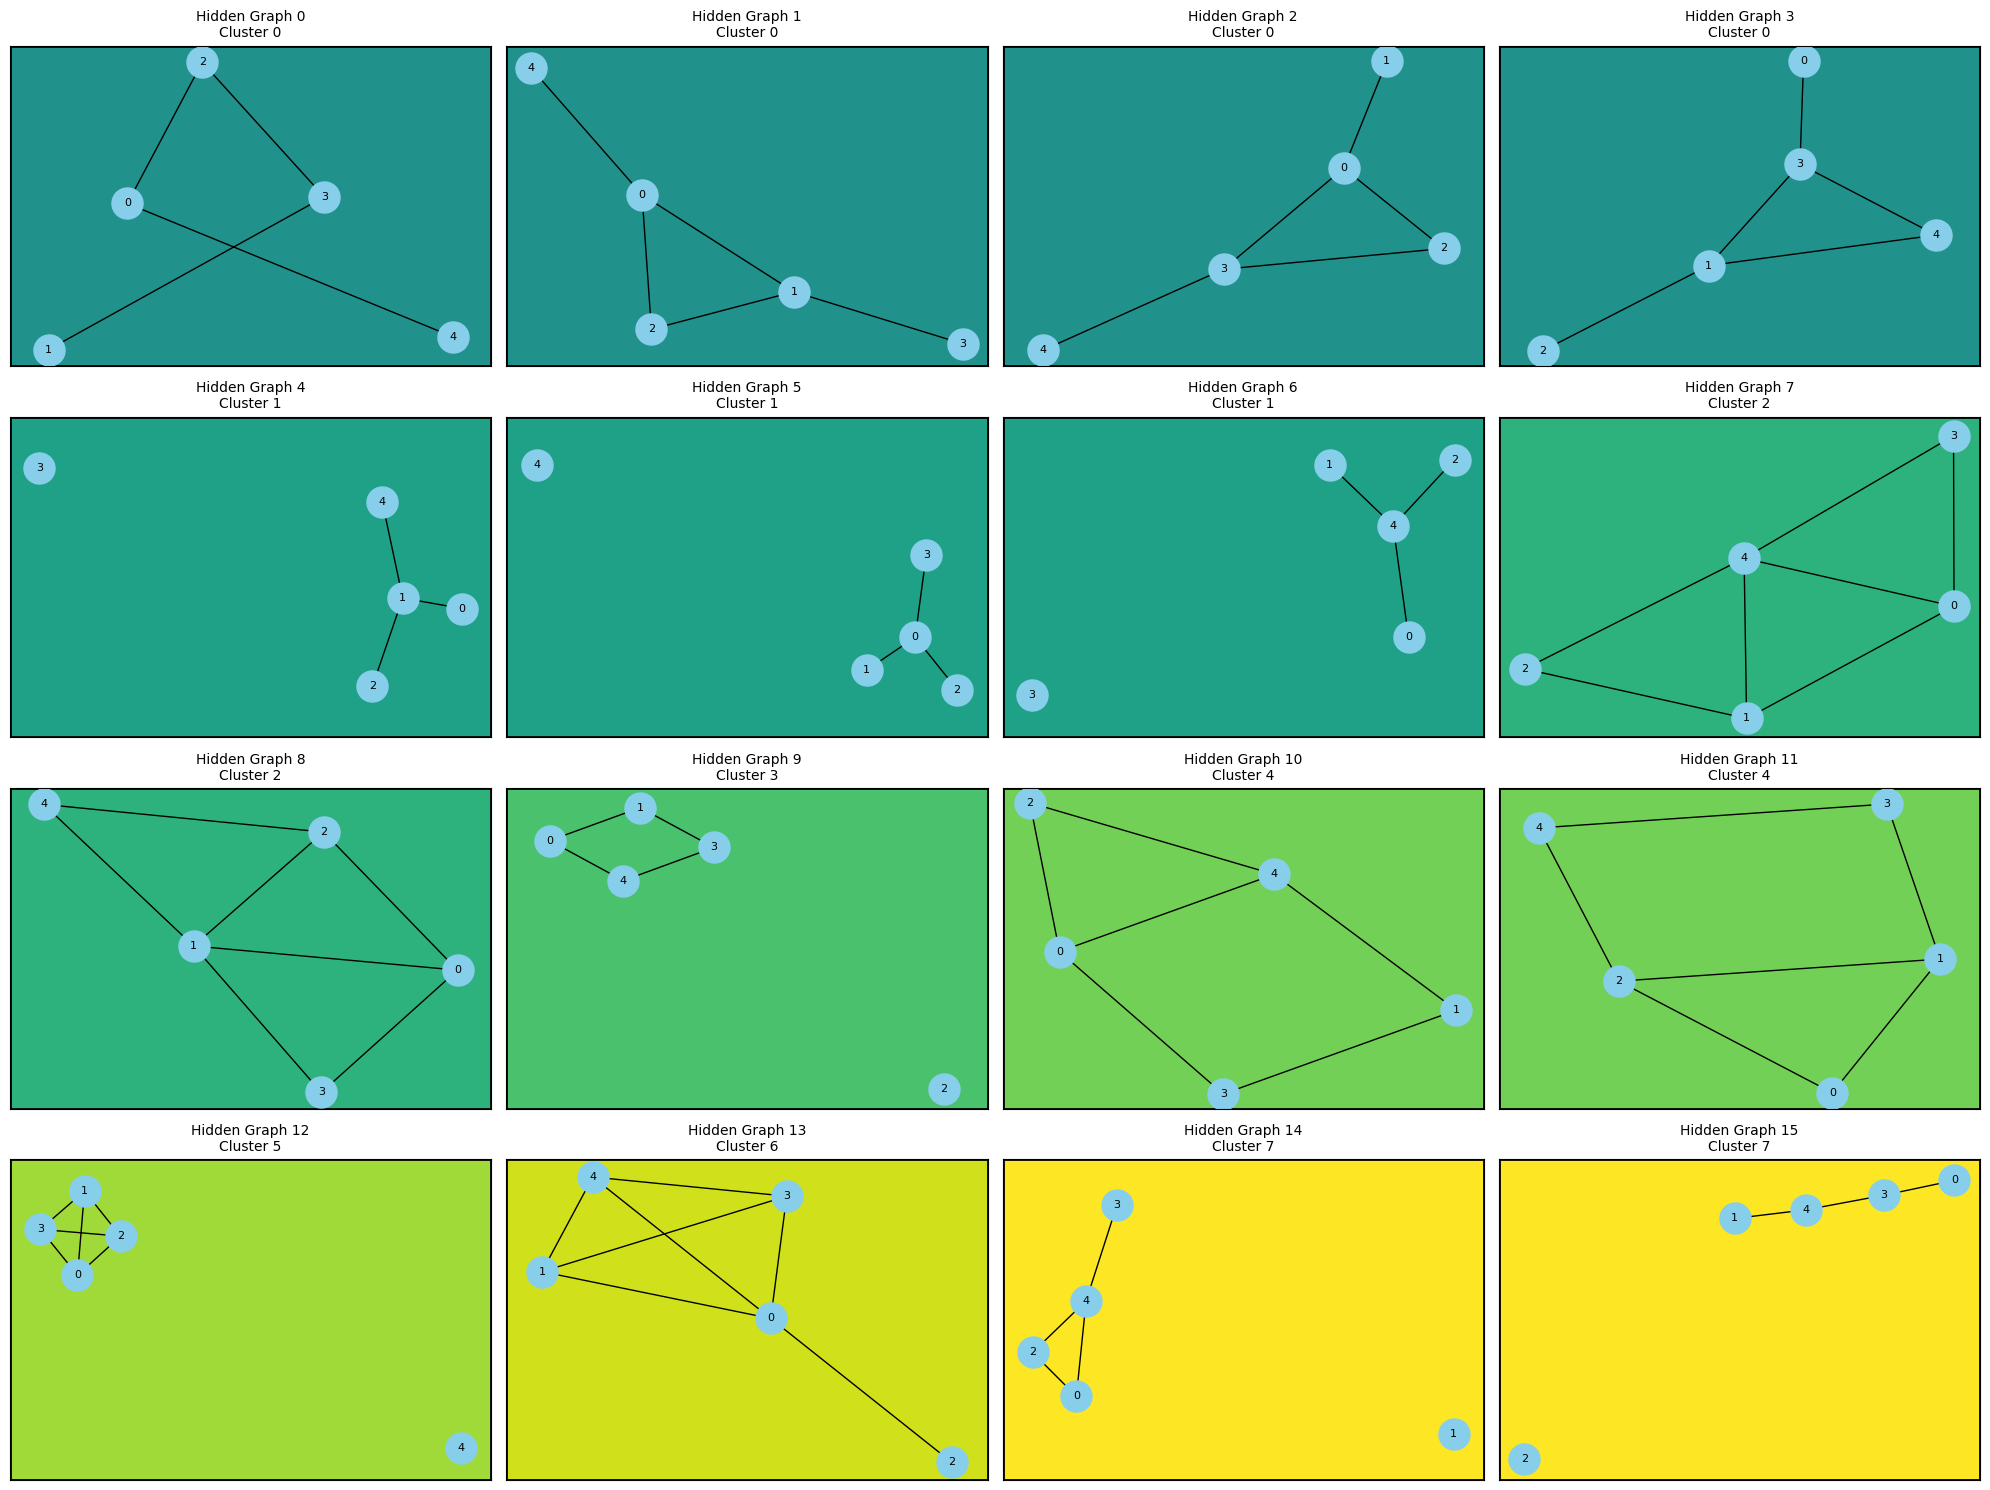

In [9]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

# Assuming adjacency_lists is a list of dictionaries where each dictionary
# represents the adjacency list of a hidden graph.
adjacency_lists = model.get_hidden_graphs_adjacency_list()
cluster_labels = model.get_cluster_lables()

# Define a mapping from clusters to pale colors
# Ensure there are enough colors by generating more if needed
unique_clusters = sorted(set(cluster_labels))
colors = plt.cm.viridis(np.linspace(0.5, 1, len(unique_clusters)))  # Generates enough distinct colors

cluster_to_color = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}
print(cluster_to_color)
# Pair the adjacency lists with their corresponding cluster labels and sort by cluster label
sorted_graphs = sorted(
    enumerate(adjacency_lists), 
    key=lambda x: cluster_labels[x[0]]
)
sorted_adjacency_lists = [adjacency_lists[i] for i, _ in sorted_graphs]
sorted_cluster_labels = [cluster_labels[i] for i, _ in sorted_graphs]

# Number of graphs
num_graphs = len(sorted_adjacency_lists)

# Determine grid size for displaying graphs (e.g., 4x4 for 16 graphs)
cols = 4  # Number of columns in the grid
rows = (num_graphs + cols - 1) // cols  # Calculate the required number of rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to make indexing easier

# Set figure background to white
fig.patch.set_facecolor('white')

# Iterate through each hidden graph
for i, (adj_list, cluster_label) in enumerate(zip(sorted_adjacency_lists, sorted_cluster_labels)):
    G = nx.Graph()  # Create a new graph for each hidden graph
    
    # Add edges based on the adjacency list
    for node, neighbors in adj_list.items():
        G.add_node(node)
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    # Get the current axis
    ax = axes[i]
    # Set subplot background to white
    ax.set_facecolor(cluster_to_color[cluster_label])
    
    # Compute positions for nodes
    pos = nx.spring_layout(G)
    
    # Draw edges with increased width and distinct color    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='black', width=1)

    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    
    # Adjust axis limits to ensure edges are visible
    x_vals, y_vals = zip(*pos.values())
    ax.set_xlim(min(x_vals) - 0.1, max(x_vals) + 0.1)
    ax.set_ylim(min(y_vals) - 0.1, max(y_vals) + 0.1)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a border around the subplot
    ax.add_patch(Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes, 
        linewidth=2, edgecolor='black', facecolor='none'
    ))
    
    # Set the title
    ax.set_title(f"Hidden Graph {i}\nCluster {cluster_label}", fontsize=10)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


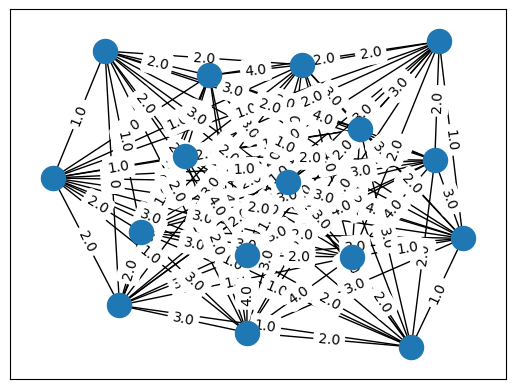

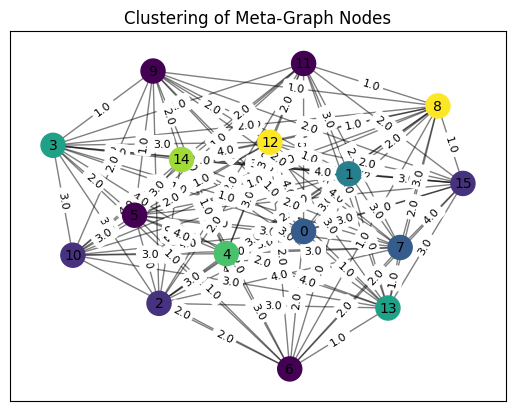

In [10]:
G = model.get_meta_graph()
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

cluster_labels = model.get_cluster_lables()
# visualize metagraph with cluster labels
pos = nx.spring_layout(G)  # Spring layout for visualization
nx.draw_networkx_nodes(G, pos, node_color=cluster_labels, cmap='viridis', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw edge labels (weights)
weights = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8)


# Add labels (optional)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Clustering of Meta-Graph Nodes")
plt.show()

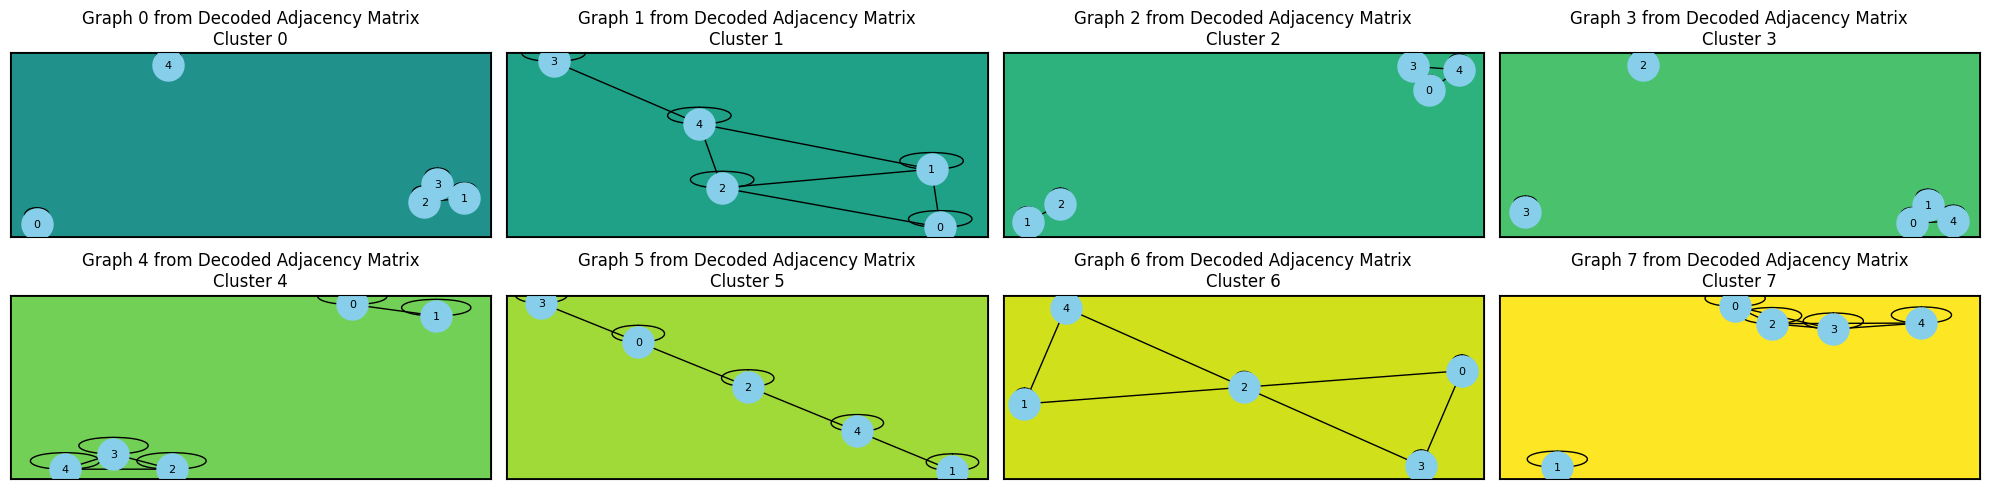

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import numpy as np  # For np.linspace if not already imported

# Assuming vgae_graphs is a list of networkx graph objects
vgae_graphs = model.get_vgae_graphs()

# 0 1 2
#   2 1
# Generate a distinct set of colors for each graph
unique_clusters = sorted(set(range(len(vgae_graphs))))  # Using the index as the cluster label
colors = plt.cm.viridis(np.linspace(0.5, 1, len(unique_clusters)))  # Generates enough distinct colors
cluster_to_color = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Determine grid size for displaying graphs (e.g., 4x4 for 16 graphs)
cols = 4  # Number of columns in the grid
rows = (len(vgae_graphs) + cols - 1) // cols  # Calculate the required number of rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 5))
axes = axes.flatten()  # Flatten to make indexing easier

# Set figure background to white
fig.patch.set_facecolor('white')

# Iterate through each VGAE graph
for i, graph in enumerate(vgae_graphs):
    ax = axes[i]  # Get the current axis
    G = graph
    
    # Add edges based on the adjacency list
    cluster_label = i  # Cluster is the index of the graph
    
    # Set background color for the axis
    ax.set_facecolor(cluster_to_color[cluster_label])  # Set background color based on cluster
    pos = nx.spring_layout(G)
    
    # Draw edges with increased width and distinct color    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='black', width=1)

    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    
    x_vals, y_vals = zip(*pos.values())
    ax.set_xlim(min(x_vals) - 0.1, max(x_vals) + 0.1)
    ax.set_ylim(min(y_vals) - 0.1, max(y_vals) + 0.1)
    # Draw the graph with default node and edge colors
    # nx.draw(
    #     graph, with_labels=True, node_color='skyblue', edge_color='gray',
    #     node_size=2000, font_size=10, ax=ax
    # )
    
    # Set the title for each subplot
    ax.set_title(f"Graph {i} from Decoded Adjacency Matrix\nCluster {cluster_label}")

    # Remove axis ticks for a cleaner view
    ax.set_xticks([]) 
    ax.set_yticks([])

    # Add a border around the subplot (optional)
    ax.add_patch(Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes, 
        linewidth=2, edgecolor='black', facecolor='none'
    ))

# Hide any unused subplots (if there are fewer graphs than grid spaces)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
